In [163]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drugs-side-effects-drugs-com/drugs_side_effects_drugs_com.csv


<h1 style="text-align: center; font-size: 3em; color: #38B1B5; font-family: 'Arial', sans-serif;">
   ! Interactive Pharmaceutical Visualization Data with <span style="color: #CED067;">ML</span> - Analysis & Understanding ~
</h1>



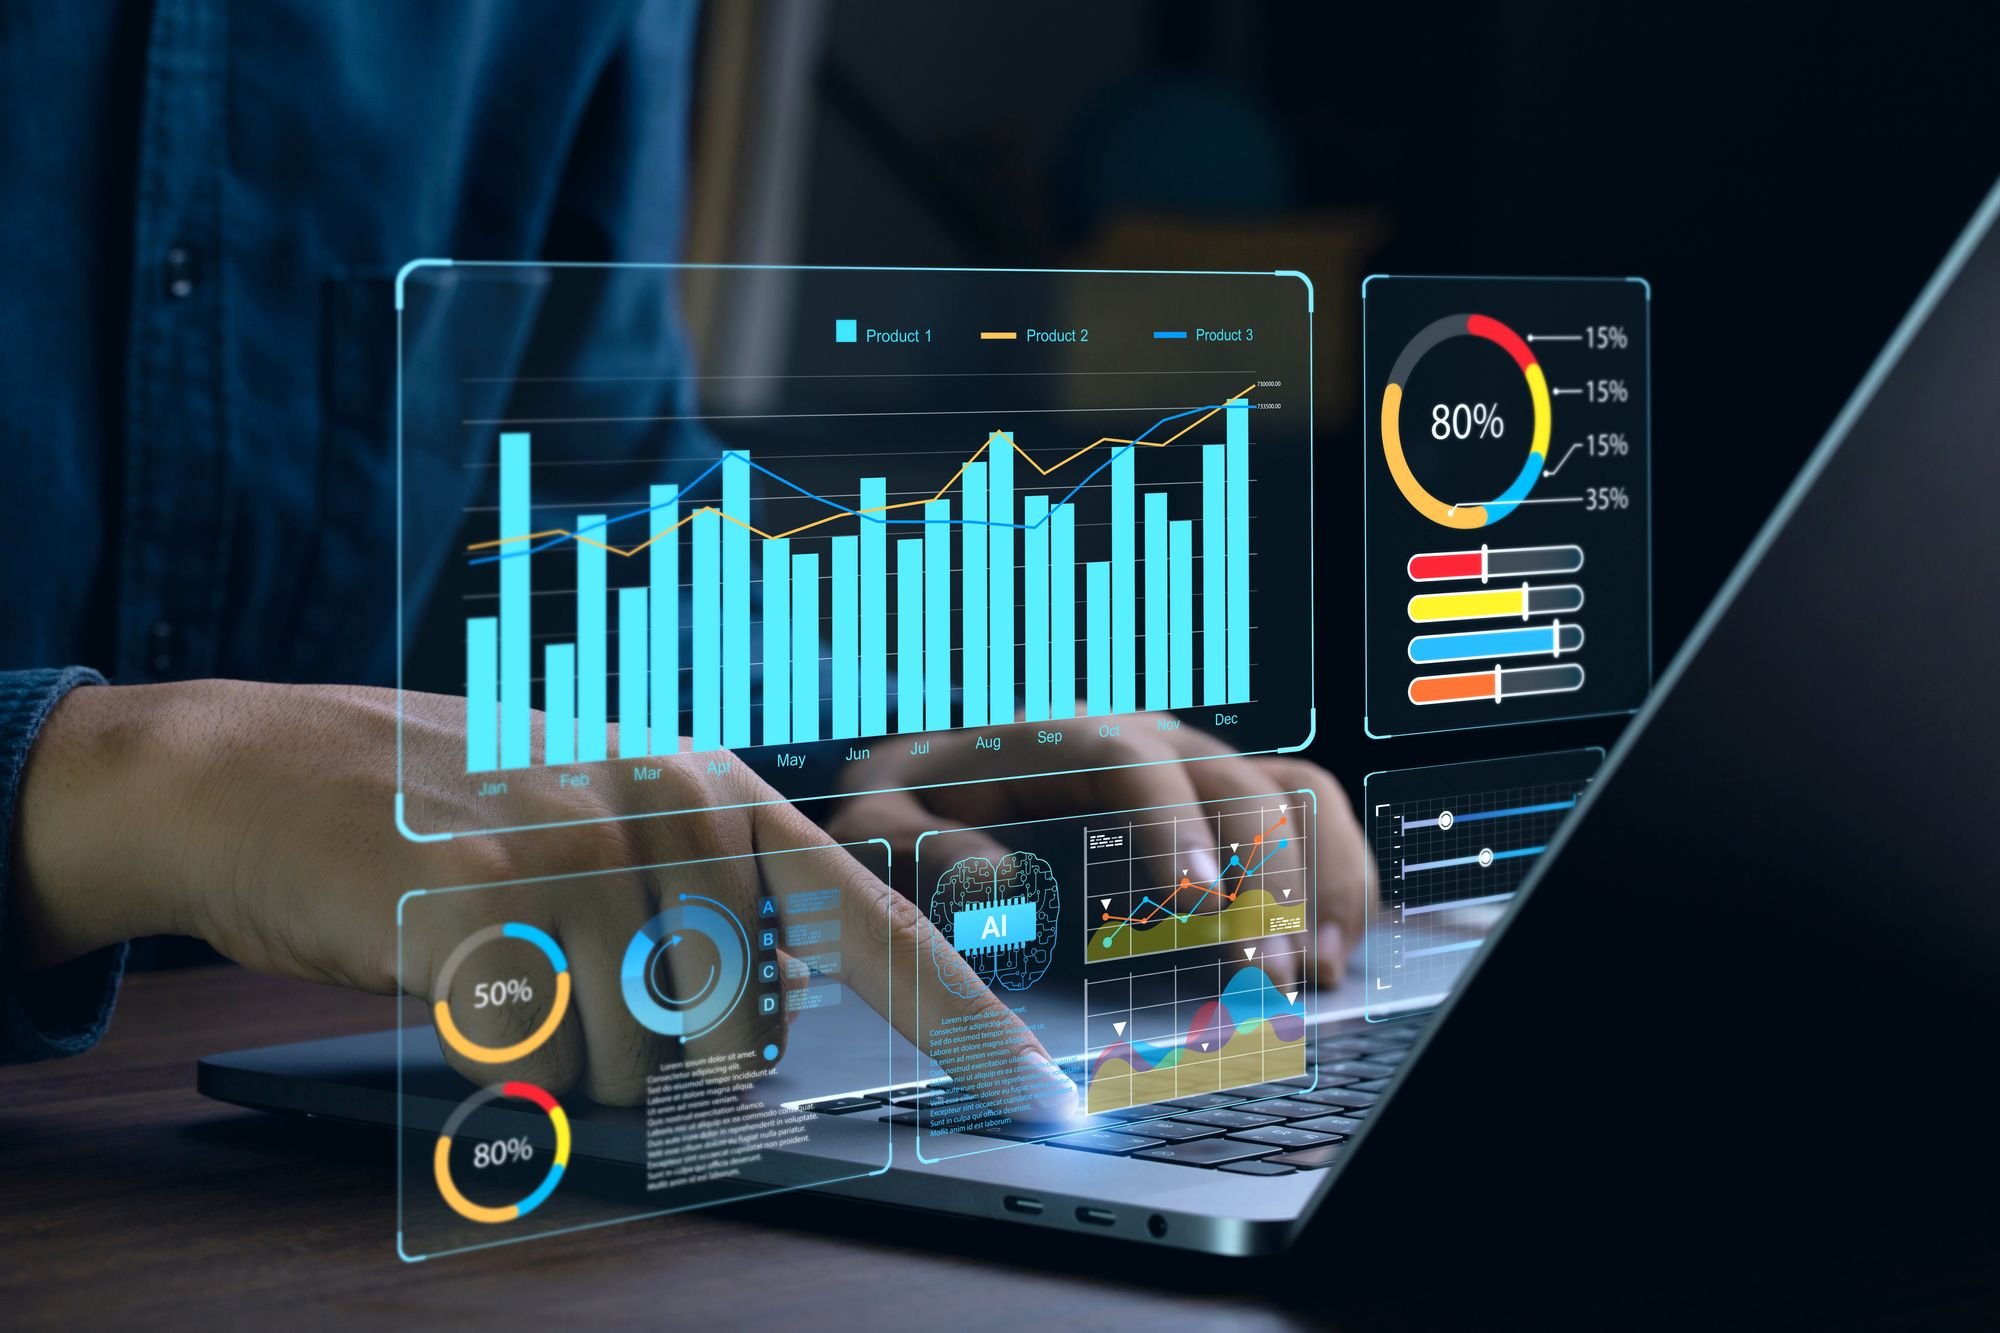

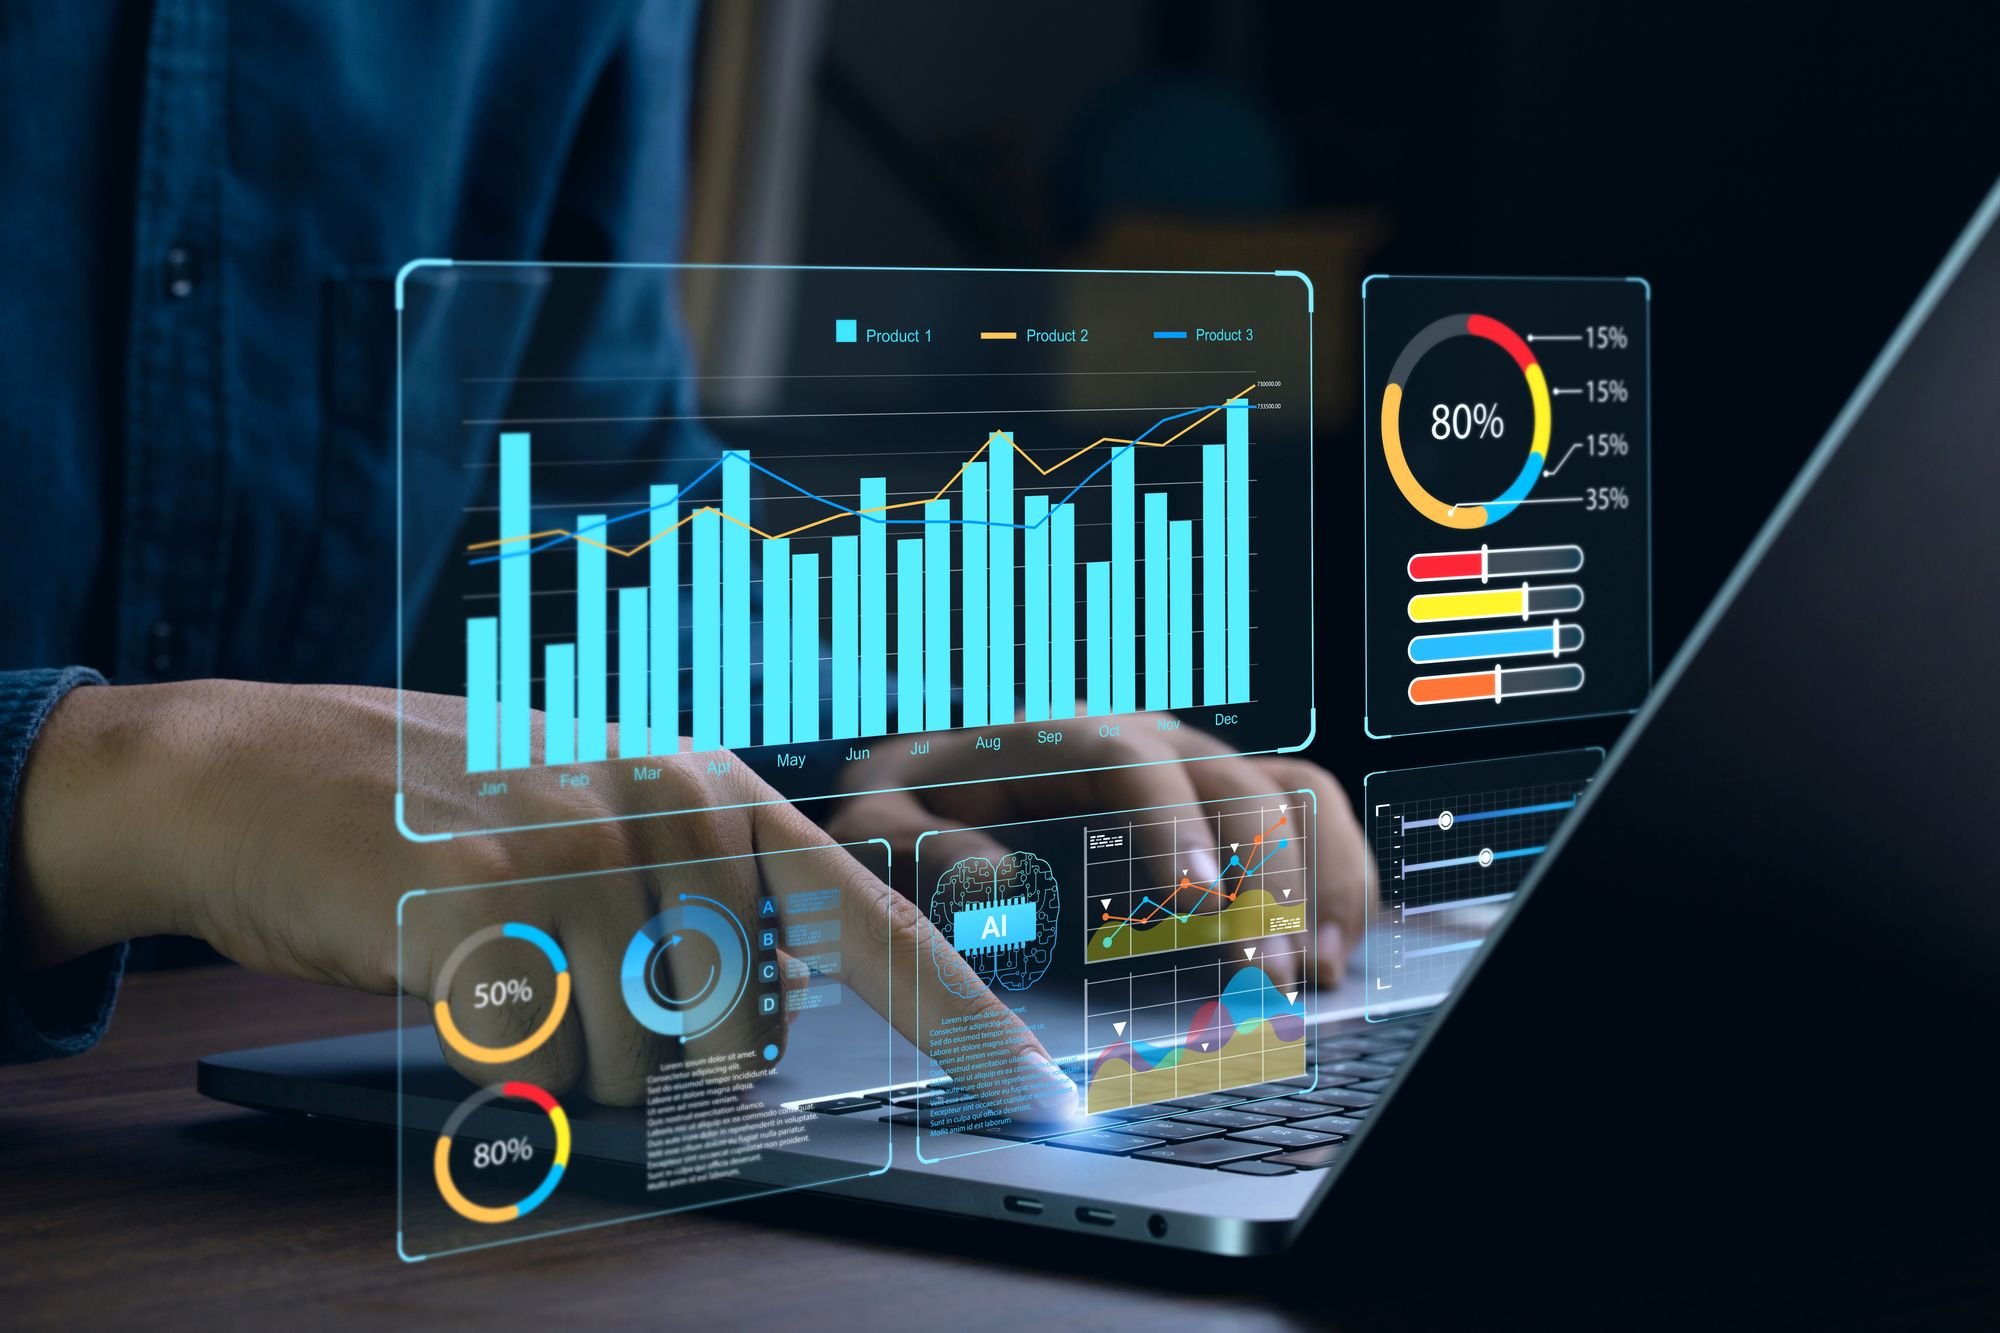

>  Exploratory Data Analysis on Drugs, Side Effects, and Medical Conditions

In [164]:
!pip install twython

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer

In [166]:
data = pd.read_csv('/kaggle/input/drugs-side-effects-drugs-com/drugs_side_effects_drugs_com.csv')

In [167]:
data.head()

,drug_name,medical_condition,side_effects,generic_name,drug_classes,brand_names,activity,rx_otc,pregnancy_category,csa,alcohol,related_drugs,medical_condition_description,rating,no_of_reviews,drug_link,medical_condition_url
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",doxycycline,"Miscellaneous antimalarials, Tetracyclines","Acticlate, Adoxa CK, Adoxa Pak, Adoxa TT, Alod...",87%,Rx,D,N,X,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,6.8,760.0,https://www.drugs.com/doxycycline.html,https://www.drugs.com/condition/acne.html
1,spironolactone,Acne,hives ; difficulty breathing; swelling of your...,spironolactone,"Aldosterone receptor antagonists, Potassium-sp...","Aldactone, CaroSpir",82%,Rx,C,N,X,amlodipine: https://www.drugs.com/amlodipine.h...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.2,449.0,https://www.drugs.com/spironolactone.html,https://www.drugs.com/condition/acne.html
2,minocycline,Acne,"skin rash, fever, swollen glands, flu-like sym...",minocycline,Tetracyclines,"Dynacin, Minocin, Minolira, Solodyn, Ximino, V...",48%,Rx,D,N,NaN,amoxicillin: https://www.drugs.com/amoxicillin...,Acne Other names: Acne Vulgaris; Blackheads; B...,5.7,482.0,https://www.drugs.com/minocycline.html,https://www.drugs.com/condition/acne.html
3,Accutane,Acne,problems with your vision or hearing; muscle o...,isotretinoin (oral),"Miscellaneous antineoplastics, Miscellaneous u...",NaN,41%,Rx,X,N,X,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.9,623.0,https://www.drugs.com/accutane.html,https://www.drugs.com/condition/acne.html
4,clindamycin,Acne,hives ; difficult breathing; swelling of your ...,clindamycin topical,"Topical acne agents, Vaginal anti-infectives","Cleocin T, Clindacin ETZ, Clindacin P, Clindag...",39%,Rx,B,N,NaN,doxycycline: https://www.drugs.com/doxycycline...,Acne Other names: Acne Vulgaris; Blackheads; B...,7.4,146.0,https://www.drugs.com/mtm/clindamycin-topical....,https://www.drugs.com/condition/acne.html


# Handling Missing Values

In [168]:

missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 drug_name                           0
medical_condition                   0
side_effects                      124
generic_name                       43
drug_classes                       82
brand_names                      1213
activity                            0
rx_otc                              1
pregnancy_category                229
csa                                 0
alcohol                          1554
related_drugs                    1469
medical_condition_description       0
rating                           1345
no_of_reviews                    1345
drug_link                           0
medical_condition_url               0
dtype: int64


# Impute missing values for numeric columns using median

In [169]:
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='median')
data[num_cols] = imputer.fit_transform(data[num_cols])

# Impute missing values for categorical columns using the most frequent value


In [170]:

cat_cols = data.select_dtypes(include=['object']).columns
imputer = SimpleImputer(strategy='most_frequent')
data[cat_cols] = imputer.fit_transform(data[cat_cols])

#  Handling Outliers (Example: Removing outliers in drug ratings)

In [171]:

Q1 = data['rating'].quantile(0.25)
Q3 = data['rating'].quantile(0.75)
IQR = Q3 - Q1
data = data[(data['rating'] >= (Q1 - 1.5 * IQR)) & (data['rating'] <= (Q3 + 1.5 * IQR))]


# Encoding Categorical Variables

In [197]:
label_encoder = LabelEncoder()
data['drug_classes'] = label_encoder.fit_transform(data['drug_classes'])


# Drug Classes Distribution

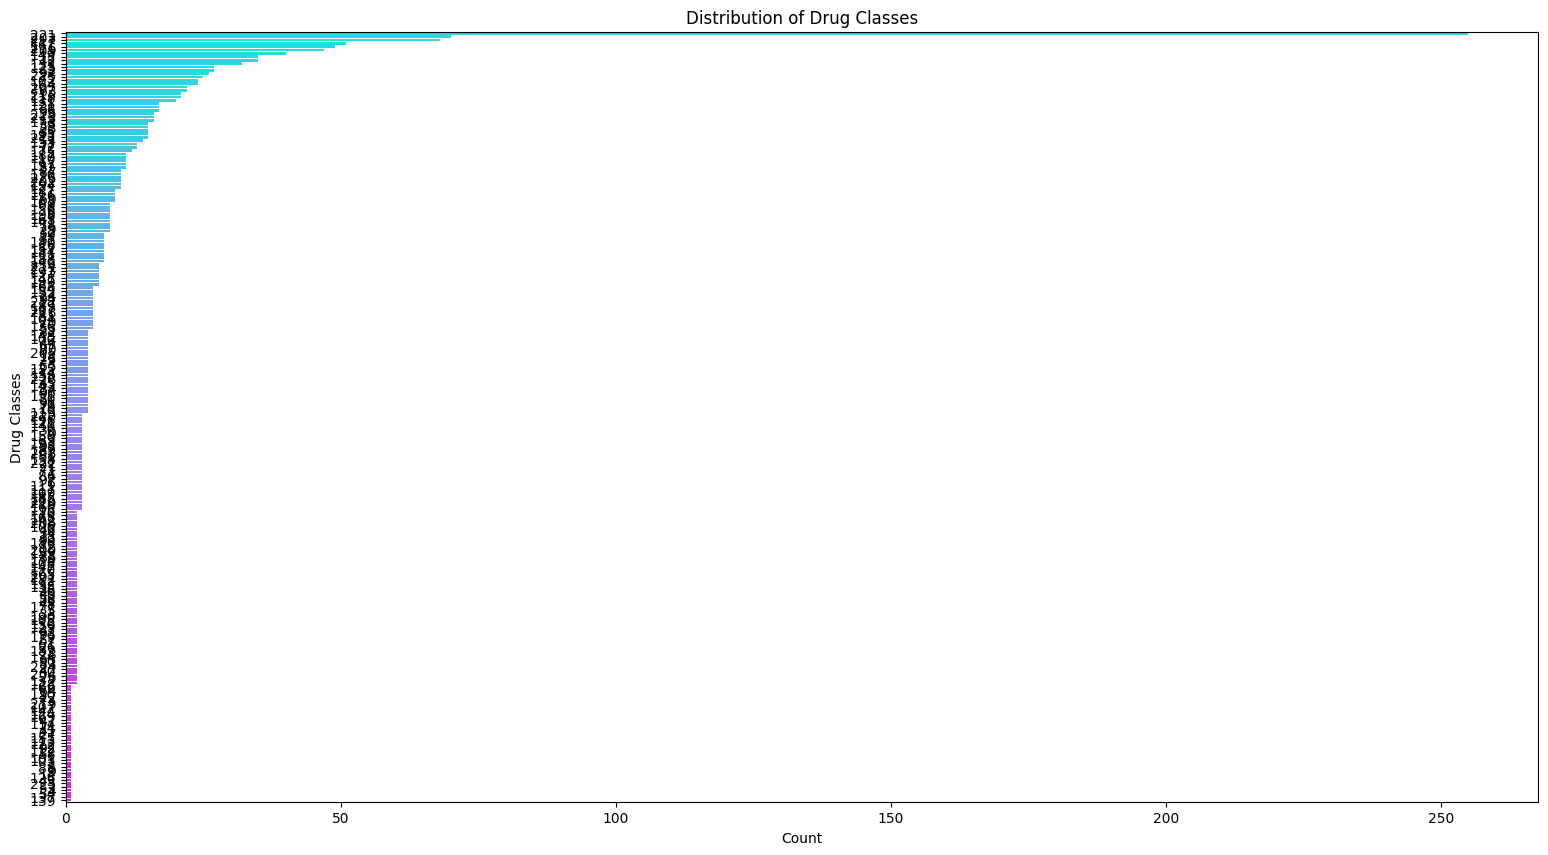

In [173]:
plt.figure(figsize=(19, 10))
sns.countplot(data=data, y='drug_classes', order=data['drug_classes'].value_counts().index, palette="cool")
plt.title("Distribution of Drug Classes")
plt.xlabel("Count")
plt.ylabel("Drug Classes")
plt.show()

# Rx vs OTC Analysis

In [196]:
rx_otc_distribution = data['rx_otc'].value_counts()
fig = px.pie(values=rx_otc_distribution.values, names=rx_otc_distribution.index, title="Rx vs OTC Distribution", color_discrete_sequence=px.colors.qualitative.Set2)
fig.show()

# Pregnancy Category Distribution

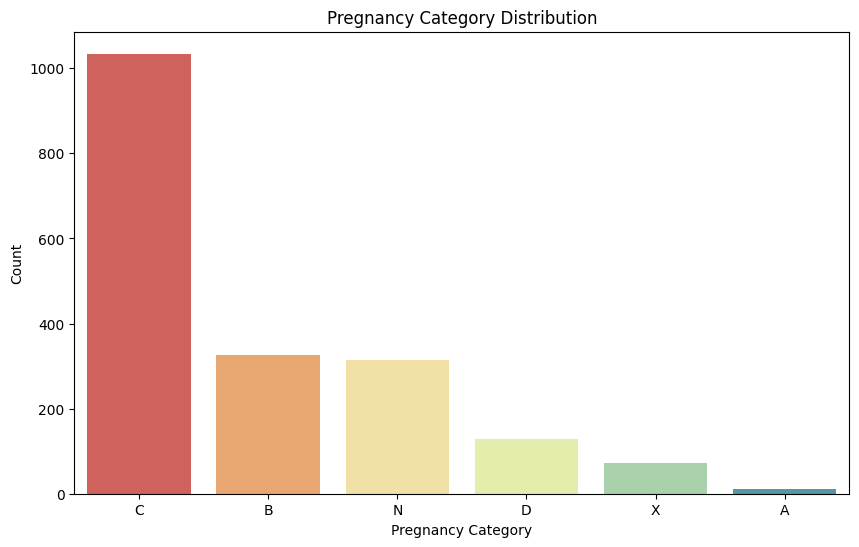

In [175]:
pregnancy_counts = data['pregnancy_category'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=pregnancy_counts.index, y=pregnancy_counts.values, palette="Spectral")
plt.title("Pregnancy Category Distribution")
plt.xlabel("Pregnancy Category")
plt.ylabel("Count")
plt.show()

# CSA Schedule Analysis

In [195]:
csa_distribution = data['csa'].value_counts()
fig = px.bar(x=csa_distribution.index, y=csa_distribution.values, color=csa_distribution.index,
             title="Controlled Substances Act (CSA) Schedule Distribution",
             color_discrete_sequence=px.colors.qualitative.Pastel1)
fig.update_layout(xaxis_title="CSA Schedule", yaxis_title="Count")
fig.show()

# Interaction Between Pregnancy Category and CSA

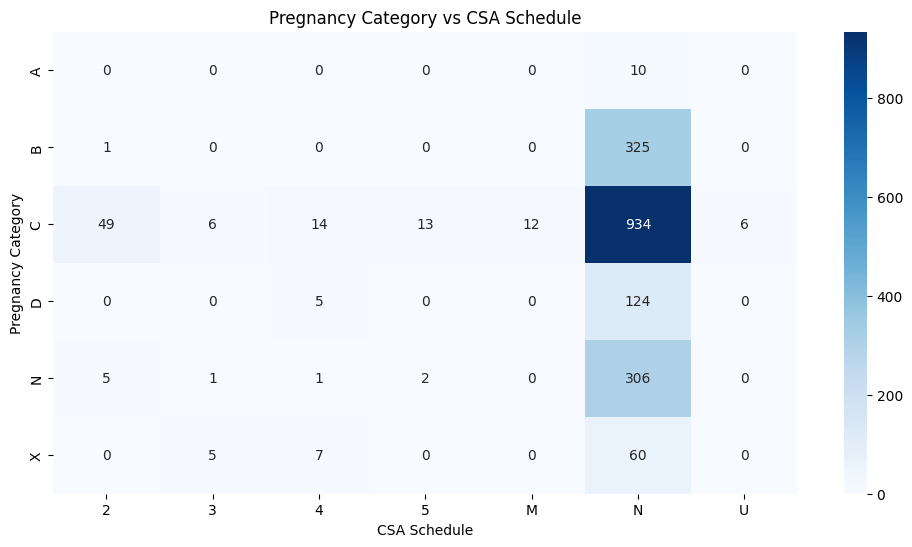

In [177]:
plt.figure(figsize=(12, 6))
sns.heatmap(pd.crosstab(data['pregnancy_category'], data['csa']), annot=True, cmap="Blues", fmt='d')
plt.title("Pregnancy Category vs CSA Schedule")
plt.xlabel("CSA Schedule")
plt.ylabel("Pregnancy Category")
plt.show()


# Alcohol Interaction Analysis

In [178]:
alcohol_interaction = data['alcohol'].value_counts()
fig = px.bar(alcohol_interaction, x=alcohol_interaction.index, y=alcohol_interaction.values, title="Alcohol Interaction",
             labels={"x": "Alcohol Interaction", "y": "Count"}, color=alcohol_interaction.index, color_discrete_sequence=px.colors.sequential.Sunset)
fig.show()

# Activity Analysis by Drug Classes

In [179]:
try:
    data['activity'] = pd.to_numeric(data['activity'].str.replace('%', ''), errors='coerce') / 100
except AttributeError:
    pass

activity_by_class = data.groupby('drug_classes')['activity'].mean().dropna().sort_values(ascending=False)
fig = px.bar(activity_by_class, title="Average Activity by Drug Classes", color=activity_by_class.index,
             color_discrete_sequence=px.colors.diverging.Tealrose)
fig.update_layout(xaxis_title="Drug Classes", yaxis_title="Average Activity")
fig.show()

# Correlation Heatmap (for Numerical Columns)

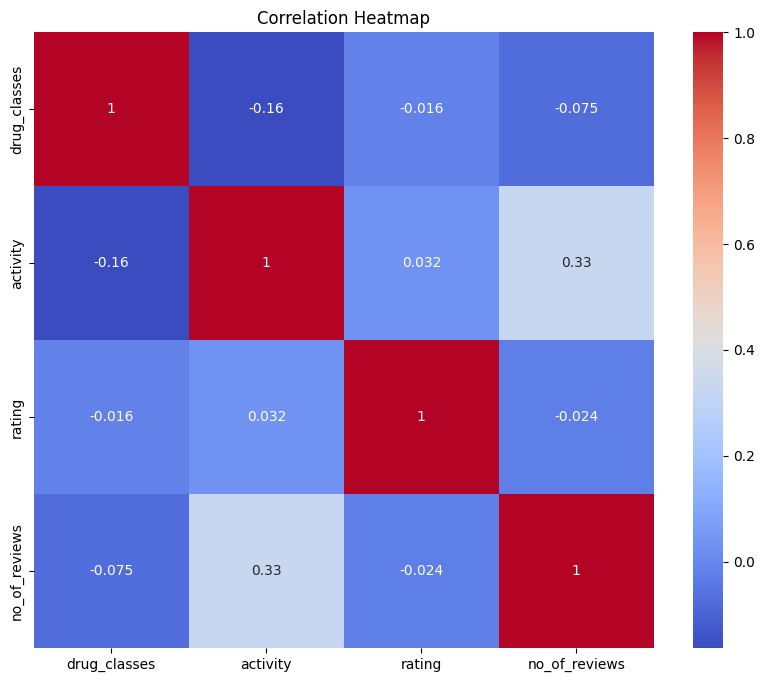

In [180]:

plt.figure(figsize=(10, 8))
sns.heatmap(data.select_dtypes(include=[np.number]).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Univariate Analysis : Distribution of drug ratings with Plotly

In [181]:
fig = px.histogram(data, x="rating", nbins=20, title="Distribution of Drug Ratings", labels={"rating": "Drug Rating"})
fig.show()

# Bivariate Analysis :Relationship between drug class and average rating

In [182]:
avg_rating_by_class = data.groupby('drug_classes')['rating'].mean().sort_values(ascending=False)
fig = px.bar(x=avg_rating_by_class.index, y=avg_rating_by_class.values, title="Average Drug Rating by Drug Class",
             labels={'x': 'Drug Class', 'y': 'Average Rating'})
fig.show()

### Multivariate Analysis: 
#### Relationship between Pregnancy Category, Drug Class, and Average Rating Using Boxplot


In [183]:
fig = px.box(data, x='pregnancy_category', y='rating', color='drug_classes', title="Drug Rating by Pregnancy Category and Drug Class")
fig.show()

# Side Effects Analysis with Top 20 Side Effects

In [184]:
side_effects = data['side_effects'].str.split(',').explode().value_counts()[:20]
fig = px.bar(x=side_effects.values, y=side_effects.index, title="Top 20 Reported Side Effects", 
             labels={"x": "Frequency", "y": "Side Effects"})
fig.show()

# Top 5 Reported Side Effects

In [185]:
side_effects = data['side_effects'].str.split(',').explode().value_counts()[:5]


fig = px.bar(side_effects, 
             x=side_effects.values, 
             y=side_effects.index, 
             title="Top 5 Reported Side Effects", 
             labels={"x": "Frequency", "y": "Side Effects"},
             orientation='h',  
             color=side_effects.values,  
             color_continuous_scale='Viridis'  
            )


fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',  
    paper_bgcolor='rgba(255,255,255,1)',  
    font=dict(family="Arial, sans-serif", size=14, color="black"),  
    title_font=dict(size=18, family='Verdana', color='rgb(23, 43, 77)'), 
    xaxis_title_font=dict(size=16, color='rgb(23, 43, 77)'), 
    yaxis_title_font=dict(size=16, color='rgb(23, 43, 77)'),  
    showlegend=False  
)


fig.show()


# Sentiment analysis using VADER

In [186]:
sia = SentimentIntensityAnalyzer()
data['sentiment_score'] = data['no_of_reviews'].apply(lambda x: sia.polarity_scores(str(x))['compound'])


# Sentiment Scores vs Number of Reviews

In [187]:

fig = px.scatter(data, 
                 x='no_of_reviews', 
                 y='sentiment_score', 
                 title="Sentiment Scores vs Number of Reviews", 
                 labels={"no_of_reviews": "Number of Reviews", "sentiment_score": "Sentiment Score"},
                 color='sentiment_score',  
                 color_continuous_scale=['yellow', 'pink'],  
                 height=600)


fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',  
    paper_bgcolor='rgba(255,255,255,1)',  
    font=dict(family="Arial, sans-serif", size=14, color="black"),  
    title_font=dict(size=18, family='Verdana', color='rgb(23, 43, 77)'), 
    xaxis_title_font=dict(size=16, color='rgb(23, 43, 77)'),  
    yaxis_title_font=dict(size=16, color='rgb(23, 43, 77)')   
)

# Show the plot
fig.show()

# Sentiment score distribution

In [188]:
fig = px.histogram(data, x="sentiment_score", nbins=20, title="Sentiment Score Distribution of Reviews")

fig.update_layout(
    xaxis_title="Sentiment Score",
    yaxis_title="Frequency",
    template="plotly_white"
)


fig.show()

# Text Analysis for Medical Condition Descriptions

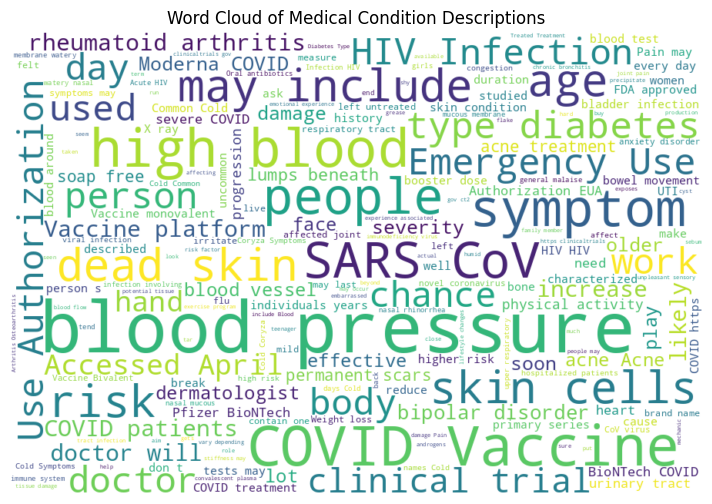

In [189]:

text = ' '.join(data['medical_condition_description'].dropna())
wordcloud = WordCloud(width=900, height=600, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Medical Condition Descriptions")
plt.show()

# Predictive Modeling  (Random Forest Regressor )  : druging a ratings based on features like 'drug_classes', 'side_effects', and 'pregnancy_category'

In [190]:
X = data[['drug_classes', 'pregnancy_category']]
y = data['rating']


In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [192]:

categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns


ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(), categorical_columns)],
    remainder='passthrough'
)

X_train_encoded = ct.fit_transform(X_train)



# Training the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_encoded, y_train)


RandomForestRegressor(random_state=42)

In [193]:
X_test_encoded = ct.transform(X_test) 
# predictions
y_pred = rf.predict(X_test_encoded)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 0.12247275872518869
R-squared Score: -0.13077658497728617


# Feature Importance

In [194]:

feature_names = ct.get_feature_names_out()

# Create a series for feature importance
feature_importance = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

# Visualize feature importance
import plotly.express as px
fig = px.bar(feature_importance, title="Feature Importance", labels={'index': 'Features', 'value': 'Importance'})
fig.show()
